# TikTok Echo Chamber Model

## Background

The TikTok Echo Chamber model seeks to simulate the creation and sustenance of echo chambers on TikTok via bot to bot interactions. It utilizes agent-based modelling to demonstrate how agents - human or bot - of varying political leanings - conservative, progressive or neutral - interact with one another and take-on/lose each other's political leanings, eventually finding themselves surrounded by agents with similar leanings.

The model categorizes interactions like following, sharing, commenting and liking as positive interactions since they promote connection and increase the likelihood of political leanings being adopted. Conversely, interactions like unfollowing and disliking are thus categorized as negative interactions.

Agents are randomly placed on a graph. Human agents start off neutral to reflect a non-tailored For You Page (FYP) when a new user joins TikTok. There is at least one bot agent in the network and bot agents, as in real life, start off with a non-neutral political leaning with the goal of spreading that leaning. Human agents are able to have positive or negative interactions with other agents, while bot agents can only have positive interactions since they aim to spread their leanings. Upon a positive interaction, an agent tries to pass on its leaning to another. Upon a negative interaction, the receiving agent will try to change its political leaning to something other than the initiating agent's.

While individual human agents may interact with others of dissimilar leanings, the amplification of some leaning by bots near the human agent nonetheless leads to clusters of similar leanings.

## Implementation

This is a demonstration of running the TikTok Echo Chamber model in an IPython Notebook. The actual model and agent code are implemented in the src directory of this Github repo. Below, we will import the model class, instantiate it, run it, and plot the time series of the number of happy agents.

Please note that you may have to edit the source code since imports may not be identified in different settings. If the below import fails, make the following changes

In src/app.py change:
<code>from agents import</code> to <code>from src.agents import</code>
<code>from model import</code> to <code>from src.model import</code>

In src/model.py change:
<code>from agents import</code> to <code>from src.agents import</code>

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

from src.model import TikTokEchoChamber

Now we instantiate a model instance: 10 nodes with 1-2 bot nodes and an average node degree of 3. The likelihood of agents to have a positive interaction with others is 40%, with a 30% chance to pass on their leaning. After a negative interaction, they have a 50% chance to become neutral.

In [13]:
ttec_model = TikTokEchoChamber(
    num_nodes=10,
    avg_node_degree=3,
    num_cons_bots=1,
    num_prog_bots=1,
    positive_chance=0.4,
    become_neutral_chance=0.5,
    seed=42
)

The model will run until all agents are of non-neutral leaning. However, there's no guarantee that a given model instantiation will *ever* settle down. So it will run for either 100 steps or until it stops on its own, whichever comes first:

In [14]:
while ttec_model.running and ttec_model.steps < 100:
    ttec_model.step()
print(f"Number of Steps {ttec_model.steps}")  # Show how many steps have actually run

Number of Steps 9


Generate a pandas DataFrame of the number of conservative, progressive and neutral agent counts at the end of each step.

In [15]:
model_out = ttec_model.datacollector.get_model_vars_dataframe()
model_out.head()

Conservative  Progressive  Neutral
0             1            1        8
1             5            2        3
2             1            3        6
3             1            5        4
4             2            3        5

Now show the cluster metrics at the end of each step. This is in a specific table of the datacollector.

In [16]:
cluster_out = ttec_model.datacollector.get_table_dataframe("CA")
cluster_out.head()

Clusters  Num_Clusters  Avg_Cluster_Size  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]            10          1.000000   
1  [0, 1, 1, 1, 1, 1, 0, 7, 8, 9]             5          2.000000   
2  [0, 1, 2, 2, 4, 0, 0, 2, 8, 2]             5          2.000000   
3  [0, 1, 2, 2, 0, 0, 0, 0, 8, 2]             4          2.500000   
4  [0, 1, 2, 2, 0, 1, 0, 2, 2, 2]             3          3.333333   

   Clstr_Agent_Ratio  Cross_Interactions  
0                1.0                   0  
1                0.5                   0  
2                0.5                  10  
3                0.4                  10  
4                0.3                  10

Finally, plot both series - political leanings and cluster analysis:

<Axes: >

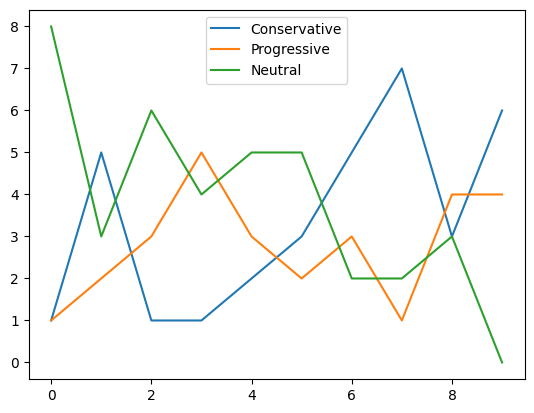

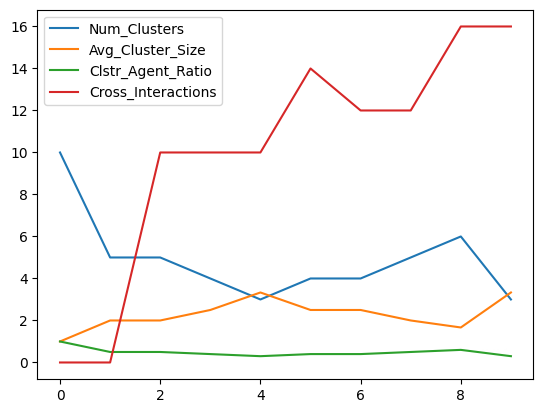

In [17]:
model_out.plot()
cluster_out.plot()

Below we do a parameter sweep to see how the number of clusters changes with the number of bots.

First, we create a function which takes a model instance and returns the number of clusters ie. agents in  proximity to one another which also have similar leanings.

In [18]:
from batchrunner import batch_run

Now, we set up the batch run, with a dictionary of fixed and changing parameters. Let's keep everything fixed except for the Number of Bots. This will be deduced from the sum of Conservative and Progressive bots.

In [19]:
fixed_params = {"num_nodes": 30, "avg_node_degree": 3, "positive_chance": 0.5, "become_neutral_chance": 0.5}
variable_params = {"num_cons_bots": range(1, 9), "num_prog_bots": range(1, 9)}
all_params = fixed_params | variable_params

In [20]:
results = batch_run(
    TikTokEchoChamber,
    parameters=all_params,
    iterations=10,
    max_steps=200,
)

# get dataframe of results
df = pd.DataFrame(results)
df

  0%|          | 0/640 [00:00<?, ?it/s]

title CA columns {'Clusters': [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [0, 1, 2, 3, 4, 5, 4, 7, 8, 9, 10, 11, 12, 13, 14, 12, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [0, 1, 2, 2, 4, 2, 0, 7, 8, 9, 10, 11, 12, 13, 4, 12, 16, 17, 18, 19, 20, 21, 0, 23, 12, 25, 26, 1, 28, 0], [0, 0, 2, 2, 0, 2, 0, 7, 8, 0, 0, 11, 12, 13, 0, 12, 0, 17, 18, 19, 20, 21, 7, 0, 12, 25, 0, 0, 28, 29], [0, 1, 2, 2, 0, 2, 0, 2, 8, 0, 0, 11, 1, 13, 0, 15, 16, 15, 18, 19, 20, 21, 22, 0, 24, 25, 26, 27, 2, 22], [0, 1, 2, 3, 4, 1, 0, 3, 8, 4, 10, 11, 1, 13, 4, 15, 16, 17, 18, 19, 20, 21, 3, 23, 24, 25, 26, 3, 3, 0], [0, 1, 2, 1, 0, 1, 0, 0, 8, 0, 0, 11, 1, 13, 0, 1, 16, 1, 18, 19, 20, 21, 0, 0, 24, 25, 26, 27, 28, 29], [0, 1, 2, 1, 4, 1, 4, 7, 8, 4, 4, 11, 1, 13, 4, 1, 16, 17, 18, 19, 20, 21, 7, 23, 24, 4, 26, 27, 28, 0], [0, 0, 0, 0, 0, 5, 0, 7, 8, 0, 10, 11, 5, 0, 0, 0, 0, 0, 18, 19, 20, 21, 22, 0, 24, 0, 0, 27, 0, 22], [0, 1, 

RunId  iteration  Step  num_nodes  avg_node_degree  positive_chance  \
0        0          0   200         30                3              0.5   
1        1          0    83         30                3              0.5   
2        2          0   200         30                3              0.5   
3        3          0    52         30                3              0.5   
4        4          0    52         30                3              0.5   
..     ...        ...   ...        ...              ...              ...   
635    635          9    27         30                3              0.5   
636    636          9     6         30                3              0.5   
637    637          9    17         30                3              0.5   
638    638          9     3         30                3              0.5   
639    639          9     1         30                3              0.5   

     become_neutral_chance  num_cons_bots  num_prog_bots  Conservative  \
0                      0.5              1              1             3   
1                      0.5              1              2             3   
2                      0.5              1              3             6   
3                      0.5              1              4             2   
4                      0.5              1              5             3   
..                     ...            ...            ...           ...   
635                    0.5              8              4            17   
636                    0.5              8              5            18   
637                    0.5              8              6            11   
638                    0.5              8              7            11   
639                    0.5              8              8            15   

     Progressive  Neutral                                        CA_Clusters  \
0              1       26  [0, 0, 2, 3, 0, 3, 0, 0, 0, 0, 0, 0, 3, 13, 14...   
1             24        3  [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2              4       20  [0, 0, 0, 3, 0, 0, 0, 7, 0, 0, 10, 0, 0, 10, 1...   
3             23        5  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4             21        6  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0,...   
..           ...      ...                                                ...   
635            8        5  [0, 0, 0, 0, 4, 5, 0, 0, 0, 4, 0, 4, 0, 0, 0, ...   
636           11        1  [0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 10, 2, 2, 2, 2,...   
637           17        2  [0, 1, 1, 1, 1, 1, 0, 1, 1, 6, 1, 1, 0, 0, 0, ...   
638           14        5  [0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 14,...   
639           12        3  [0, 1, 2, 0, 0, 1, 1, 0, 1, 1, 10, 11, 0, 0, 1...   

     CA_Num_Clusters  CA_Avg_Cluster_Size  CA_Clstr_Agent_Ratio  \
0                  9             3.333333              0.300000   
1                  2            15.000000              0.066667   
2                  7             4.285714              0.233333   
3                  2            15.000000              0.066667   
4                  2            15.000000              0.066667   
..               ...                  ...                   ...   
635                3            10.000000              0.100000   
636                7             4.285714              0.233333   
637                6             5.000000              0.200000   
638                8             3.750000              0.266667   
639               12             2.500000              0.400000   

     CA_Cross_Interactions  
0                       28  
1                       22  
2                       58  
3                       16  
4                       16  
..                     ...  
635                     34  
636                     20  
637                     36  
638                     36  
639                     26  

[640 rows x 17 columns]

Plot the Effect of Number of Bots on Number of Clusters

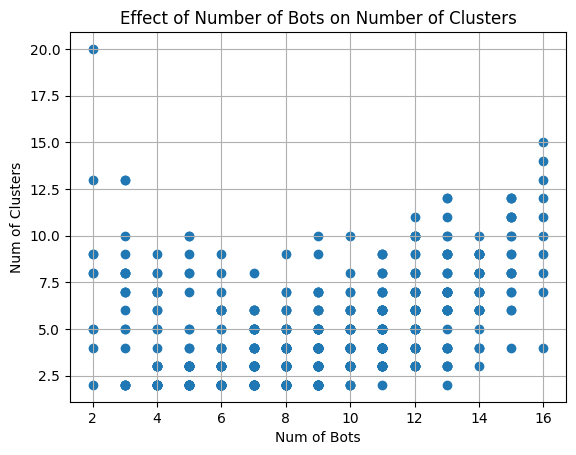

In [21]:
plt.scatter((df.num_cons_bots + df.num_prog_bots), df.CA_Num_Clusters)
plt.xlabel("Num of Bots")
plt.ylabel("Num of Clusters")
plt.grid()
plt.title("Effect of Number of Bots on Number of Clusters")
plt.show()

# Effect of Probability to Follow on Average Cluster Size

How big do clusters get when agents are more likely to connect than disconnect?

In [22]:
from numpy import arange

fixed_params2 = {"num_nodes": 20, "avg_node_degree": 3, "num_cons_bots": 2, "num_prog_bots": 2, "become_neutral_chance": 0.5}
variable_params2 = {"positive_chance": arange(0.0, 1.0, 0.1)}
all_params2 = fixed_params2 | variable_params2

results2 = batch_run(
    TikTokEchoChamber,
    parameters=all_params2,
    iterations=10,
    max_steps=200,
)

df2 = pd.DataFrame(results2)
df2

  0%|          | 0/100 [00:00<?, ?it/s]

title CA columns {'Clusters': [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10

RunId  iteration  Step  num_nodes  avg_node_degree  num_cons_bots  \
0       0          0   200         20                3              2   
1       1          0   200         20                3              2   
2       2          0   200         20                3              2   
3       3          0    35         20                3              2   
4       4          0   112         20                3              2   
..    ...        ...   ...        ...              ...            ...   
95     95          9     3         20                3              2   
96     96          9     7         20                3              2   
97     97          9     6         20                3              2   
98     98          9     9         20                3              2   
99     99          9     6         20                3              2   

    num_prog_bots  become_neutral_chance  positive_chance  Conservative  \
0               2                    0.5              0.0             2   
1               2                    0.5              0.1             6   
2               2                    0.5              0.2             4   
3               2                    0.5              0.3             7   
4               2                    0.5              0.4             6   
..            ...                    ...              ...           ...   
95              2                    0.5              0.5             4   
96              2                    0.5              0.6            16   
97              2                    0.5              0.7            15   
98              2                    0.5              0.8             2   
99              2                    0.5              0.9             2   

    Progressive  Neutral                                        CA_Clusters  \
0             2       16  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1             6        8  [0, 1, 2, 0, 0, 0, 1, 2, 8, 0, 1, 0, 1, 13, 13...   
2             5       11  [0, 0, 2, 0, 0, 2, 2, 2, 8, 8, 10, 8, 8, 13, 1...   
3            12        1  [0, 0, 0, 3, 0, 0, 0, 7, 3, 3, 0, 0, 3, 0, 7, ...   
4            12        2  [0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, ...   
..          ...      ...                                                ...   
95           13        3  [0, 1, 1, 0, 0, 0, 0, 0, 8, 1, 0, 1, 1, 0, 1, ...   
96            3        1  [0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, ...   
97            4        1  [0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, ...   
98           17        1  [0, 0, 0, 0, 0, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, ...   
99           17        1  [0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

    CA_Num_Clusters  CA_Avg_Cluster_Size  CA_Clstr_Agent_Ratio  \
0                20             1.000000                  1.00   
1                 9             2.222222                  0.45   
2                 8             2.500000                  0.40   
3                 3             6.666667                  0.15   
4                 2            10.000000                  0.10   
..              ...                  ...                   ...   
95                4             5.000000                  0.20   
96                2            10.000000                  0.10   
97                2            10.000000                  0.10   
98                3             6.666667                  0.15   
99                3             6.666667                  0.15   

    CA_Cross_Interactions  
0                       0  
1                      30  
2                      38  
3                      42  
4                      38  
..                    ...  
95                     28  
96                     40  
97                     26  
98                     16  
99                      8  

[100 rows x 17 columns]

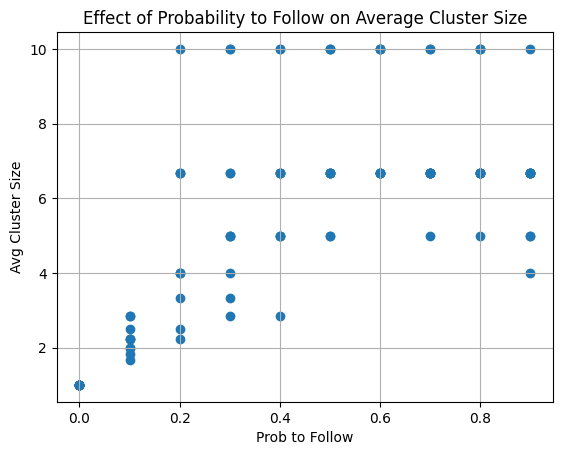

In [23]:
plt.scatter(df2.positive_chance, df2.CA_Avg_Cluster_Size)
plt.xlabel("Prob to Follow")
plt.ylabel("Avg Cluster Size")
plt.grid()
plt.title("Effect of Probability to Follow on Average Cluster Size")
plt.show()

## References

This document was adopted from the Mesa Schelling model analysis file found at the mesa examples repository on GitHub
    [https://github.com/projectmesa/mesa/tree/main/mesa/examples/basic/schelling](https://github.com/projectmesa/mesa/tree/main/mesa/examples/basic/schelling)